# Exercise set 9: Bias detection and correction
In this set you will practice: bias detection, correction, and mitigation.
Again you will use the [Toxicity classification dataset](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data) from the other exercises.
Furthermore you should download the dataset provided by Kiritchenko & Mohammed 2018 [(data)](https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip) for testing biases in text classification systems 


The classifier we will test is based on the Universal Sentence Encoder that we used in [exercise set 8](https://github.com/ulfaslak/sds_tddl_2020/blob/master/exercises/week8_exercises_transferlearning.ipynb).


## 9.0 Create function that takes in a train and test data and trains the transfer learning model from last weeks exercises. 
  - **Hint** initialize the hublayer outside the function, and use the `tf.keras.models.clone_model()` function to avoid downloading the layer everytime you reinitialize.

## 9.1 Estimate Differential Bias 
Here we shall look at both individual classification bias and proportional classification bias.
1. Train classifier on Toxicity dataset.
2. Estimate Differential Biases for each of the minority populations. i.e. white black asian jewish etc columns. 
  - You need to set a threshold of how many percent of the annotators who aggreed on the Minority group (e.g. >0.5)
  - Using the testset you should construct a confusion matrix for each minority.  
  - Report the Accuracy, Precision, Recall and F1 score.
    - Comment on the Results.
3. Test the *"Classify&Count"* method for estimating proportion for the general popolation and then for the subpopulations of each minority group.
  - See which groups have most error. 
  - Report Proportional classification accuracy using the pearsons product moment correlation (np.coercoef), and the root mean square deviation (RMSD). 



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# load dataset
import pandas as pd
path2tox_data = '/content/drive/My Drive/lm/toxic_train.csv'
tox_df = pd.read_csv(path2tox_data)

tox_df['label'] = (tox_df.target>0.5).astype(int)
print(tox_df.shape)
# subsample data to allow faster prototyping
# df = df.sample(5000) # simple solution
# stratified solution where we subsample from each meta data column to get a higher variance.
strat_sample_cols = list(tox_df.columns[3:23])+['physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']
samples = []
n = 600
for col in strat_sample_cols:
    binary = pd.DataFrame((tox_df[col]>0.5).astype(int))
    samples+=[j for _,j in binary.groupby(col).apply(lambda x: x.sample(min(len(x),n//2))).index]
idx = list(set(samples))

df = tox_df.iloc[idx].copy()
# Create evaluation set
val_size = 100000
extra_df = tox_df[~tox_df.reset_index()['index'].isin(set(idx))]
val_df = extra_df.sample(val_size)
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.33)
sample = df.groupby('label').apply(lambda x: x.sample(500))
sample_texts = sample.comment_text.values
print(df.shape,tox_df.shape)


(1804874, 46)
(13261, 46) (1804874, 46)


In [ ]:
# Solution 9.0
## Initialize hublayer outside of train_function.
import tensorflow_hub as hub
import tensorflow as tf
# Make basemodel to avoid downloading everytime.
# Add USE layer to model  
mod_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
basetfmodel = tf.keras.models.Sequential()
basetfmodel.add(hub.KerasLayer(mod_url, 
                          input_shape=[], 
                          dtype=tf.string,
                          trainable=False
                          ))

import numpy as np
def train_tranfer_USE(x_train,x_test,y_train,y_test,epochs=3):
  model = tf.keras.models.clone_model(basetfmodel)
  # Define extra layers for the pipeline.
  model.add(tf.keras.layers.Dense(256, activation='relu')) # add standard feed forward layer
  model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # define output layer.
  # Compile model.
  model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
              

  val_dat = (np.array([i for i in x_test.values]), y_test.values)
  
  # Run session and fit model.
  #with tf.compat.v1.Session() as sess:
  #with tf.Session() as sess:

    #sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
  #  sess.run([tf.compat.v1.global_variables_initializer(),tf.compat.v1.tables_initializer()])
  model.fit(x_train.values, 
              y_train.values, 
              epochs=epochs
              #,validation_split=0.2
              ,validation_data=val_dat
              )
  return model

In [3]:
tfmodel = train_tranfer_USE(train_df.comment_text,test_df.comment_text,train_df.label,test_df.label)

Epoch 1/3
278/278 [==============================] - 7s 25ms/step - loss: 0.3885 - accuracy: 0.8441 - val_loss: 0.3302 - val_accuracy: 0.8638
Epoch 2/3
278/278 [==============================] - 6s 23ms/step - loss: 0.3221 - accuracy: 0.8655 - val_loss: 0.3174 - val_accuracy: 0.8695
Epoch 3/3
278/278 [==============================] - 6s 23ms/step - loss: 0.3047 - accuracy: 0.8760 - val_loss: 0.3165 - val_accuracy: 0.8748


## Train BoW baseline using the get_bow_baseline script

In [ ]:
## Download script for searching the hyperparameters with bayesian optimization using the hyperopt package.
import requests
with open('get_bow_baseline.py','w') as f:
    f.write(requests.get('https://raw.githubusercontent.com/snorreralund/test_tokenization/master/get_bow_baseline.py').text)
f.close()

In [5]:
import get_bow_baseline as baseline
baseline = baseline.TokenizationTest(train_df,test_df,MAX_EVALS=150,scoring_function='accuracy_score',y_col='label',text_col='comment_text')
import warnings; warnings.simplefilter('ignore')
import nltk
tokenizer = nltk.tokenize.TweetTokenizer().tokenize
baseline.evaluate('nltk_tweet',tokenizer)

100%|██████████| 150/150 [04:41<00:00,  1.88s/it, best loss: 0.1538894447223612]
Final accuracy and roc_auc score of tokenizer (nltk_tweet) + nb_log: 0.883 and 0.841


In [6]:
%time y_pred = baseline.predict(val_df.comment_text.values)
val_df['bow_prob'] = y_pred[:,1]
val_df['bow_pred'] = (val_df.bow_prob > 0.5).astype(int)

CPU times: user 2.45 s, sys: 11.7 ms, total: 2.47 s
Wall time: 2.47 s


In [7]:
## Differential Classification Error
minority_columns = ['asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']
## Apply model to the texts.
%time val_df['tf_prob'] = tfmodel.predict(val_df.comment_text)
val_df['tf_prediction'] = (val_df.tf_prob>0.5).astype(int)

CPU times: user 48.5 s, sys: 3.61 s, total: 52.1 s
Wall time: 36.6 s


In [ ]:
val_df['label'] = pd.Categorical(val_df.label.astype(int))
val_df['tf_prediction'] = pd.Categorical(val_df.tf_prediction)

In [ ]:
## Estimate diffential bias. 
def get_confusion_matrix(tempdf,pred_col = 'tf_prediction',true_col = 'label'):
  mat = tempdf.groupby([pred_col,true_col]).size().unstack()

  tn = mat.values[0][0]
  fn = mat.values[0][1]
  tp = mat.values[1][1]
  fp = mat.values[1][0]
  return tn,fn,tp,fp,mat.unstack()
import sklearn.metrics
dat = []
for col in minority_columns:
  tempdf = val_df[val_df[col]>0.5]
  if len(tempdf)<50:
    continue
  tn,fn,tp,fp,mat = get_confusion_matrix(tempdf)
  # Calculate performance scores
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  acc = (tp+tn)/(tp+tn+fp+fn)
  f1 = 2*(precision*recall)/(precision+recall)
  roc_auc = sklearn.metrics.roc_auc_score(tempdf.label,tempdf.tf_prob)
  ## Count true proportions
  pos = sum(tempdf.label==1.)
  neg = len(tempdf)-pos
  d = {'minority':col,'precision':precision,'recall':recall,'accuracy':acc,'roc_auc':roc_auc,'f1':f1,'tp':tp,
       'fp':fp,'tn':tn,'fn':fn,'n':len(tempdf),'pos':pos,'neg':neg}
  dat.append(d)
diff_bias = pd.DataFrame(dat).dropna().reset_index(drop=True)

In [ ]:
diff_bias.sort_values('recall')

,minority,precision,recall,accuracy,roc_auc,f1,tp,fp,tn,fn,n,pos,neg
3,buddhist,0.250000,0.071429,0.912568,0.526839,0.111111,1,3,166,13,183,14,169
14,transgender,0.457746,0.282609,0.870657,0.617843,0.349462,65,77,1564,165,1871,230,1641
9,jewish,0.451098,0.324247,0.889514,0.639415,0.377295,226,275,5780,471,6752,697,6055
0,asian,0.435233,0.324324,0.912129,0.643831,0.371681,84,109,2864,175,3232,259,2973
4,christian,0.357181,0.336495,0.926396,0.649605,0.346530,674,1213,31320,1329,34536,2003,32533
6,heterosexual,0.564516,0.336538,0.870445,0.647076,0.421687,35,27,610,69,741,104,637
8,homosexual_gay_or_lesbian,0.523052,0.355676,0.811942,0.638770,0.423423,658,600,7079,1192,9529,1850,7679
5,female,0.413432,0.356686,0.894759,0.652840,0.382969,1619,2297,42736,2920,49572,4539,45033
1,atheist,0.434211,0.358696,0.896761,0.655352,0.392857,33,43,853,59,988,92,896
10,latino,0.453846,0.401361,0.860035,0.664785,0.425993,59,71,918,88,1136,147,989


Recall shows that insults against blacks, males, and whites are captured best. Whereas Asian Transgender, and Jewish insults are harder to detect.

In [ ]:
diff_bias.sort_values('precision')

,minority,precision,recall,accuracy,roc_auc,f1,tp,fp,tn,fn,n,pos,neg
3,buddhist,0.250000,0.071429,0.912568,0.526839,0.111111,1,3,166,13,183,14,169
11,male,0.354773,0.471040,0.856803,0.686152,0.404721,1903,3461,31592,2137,39093,4040,35053
4,christian,0.357181,0.336495,0.926396,0.649605,0.346530,674,1213,31320,1329,34536,2003,32533
12,muslim,0.410345,0.464844,0.820608,0.673897,0.435897,1309,1881,14189,1507,18886,2816,16070
5,female,0.413432,0.356686,0.894759,0.652840,0.382969,1619,2297,42736,2920,49572,4539,45033
15,white,0.414293,0.569351,0.760826,0.688069,0.479600,2545,3598,15024,1925,23092,4470,18622
1,atheist,0.434211,0.358696,0.896761,0.655352,0.392857,33,43,853,59,988,92,896
0,asian,0.435233,0.324324,0.912129,0.643831,0.371681,84,109,2864,175,3232,259,2973
9,jewish,0.451098,0.324247,0.889514,0.639415,0.377295,226,275,5780,471,6752,697,6055
10,latino,0.453846,0.401361,0.860035,0.664785,0.425993,59,71,918,88,1136,147,989


Taking the differential Recall together with the differential Precision suggests that while the classifier fails to detect many jewish and asian, inssults the ones that it do capture is quite general and easy to recognize.

In [ ]:
diff_bias.sort_values('roc_auc') # Report the RoC_Auc score as the overall best performance accross minorities.

,minority,precision,recall,accuracy,roc_auc,f1,tp,fp,tn,fn,n,pos,neg
3,buddhist,0.250000,0.071429,0.912568,0.526839,0.111111,1,3,166,13,183,14,169
14,transgender,0.457746,0.282609,0.870657,0.617843,0.349462,65,77,1564,165,1871,230,1641
8,homosexual_gay_or_lesbian,0.523052,0.355676,0.811942,0.638770,0.423423,658,600,7079,1192,9529,1850,7679
9,jewish,0.451098,0.324247,0.889514,0.639415,0.377295,226,275,5780,471,6752,697,6055
0,asian,0.435233,0.324324,0.912129,0.643831,0.371681,84,109,2864,175,3232,259,2973
6,heterosexual,0.564516,0.336538,0.870445,0.647076,0.421687,35,27,610,69,741,104,637
4,christian,0.357181,0.336495,0.926396,0.649605,0.346530,674,1213,31320,1329,34536,2003,32533
5,female,0.413432,0.356686,0.894759,0.652840,0.382969,1619,2297,42736,2920,49572,4539,45033
1,atheist,0.434211,0.358696,0.896761,0.655352,0.392857,33,43,853,59,988,92,896
10,latino,0.453846,0.401361,0.860035,0.664785,0.425993,59,71,918,88,1136,147,989


Text(0.5, 0, 'Roc Auc Score')

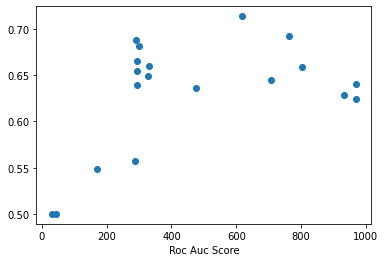

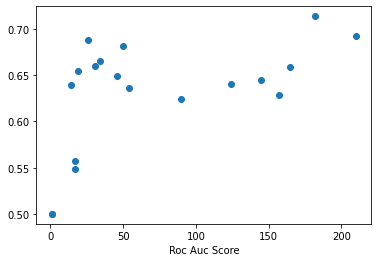

In [ ]:
# Relationship between the number of samples and the classifier performance. Use Roc_auc as it is independent of "Predicted" Class balances.
plt.scatter(diff_bias.n,diff_bias.roc_auc)
plt.xlabel('No. of samples')
plt.xlabel('Roc Auc Score')
plt.figure()
plt.scatter(diff_bias.pos,diff_bias.roc_auc)
plt.xlabel('No. of positive samples')
plt.xlabel('Roc Auc Score')

In [ ]:
## Proportional Classification Error
### For each minority column estimate the proportions.
#### Already done in the above cell.
## Sort groups by highest proportional error
diff_bias['proportional_error_abs'] = diff_bias.pos-(diff_bias.tp+diff_bias.fp)
diff_bias['proportional_error_p'] = (diff_bias.pos-(diff_bias.tp+diff_bias.fp))/diff_bias.pos
diff_bias['clf_pos_freq'] = (diff_bias.tp+diff_bias.fp) / diff_bias.n
diff_bias['pos_freq'] = diff_bias['pos']/diff_bias.n
diff_bias['proportional_error_freq'] = diff_bias['pos_freq'] - diff_bias['clf_pos_freq']
diff_bias.sort_values('proportional_error_p')[['minority','pos','pos_freq','clf_pos_freq','proportional_error_freq','proportional_error_abs','proportional_error_p']]

,minority,pos,pos_freq,clf_pos_freq,proportional_error_freq,proportional_error_abs,proportional_error_p
6,male,211,0.097325,0.105166,-0.007841,-17,-0.080569
10,white,226,0.175739,0.183515,-0.007776,-10,-0.044248
1,black,166,0.226467,0.215553,0.010914,8,0.048193
0,asian,10,0.053476,0.042781,0.010695,2,0.200000
3,female,244,0.089377,0.069963,0.019414,53,0.217213
7,muslim,174,0.163534,0.103383,0.060150,64,0.367816
8,psychiatric_or_mental_illness,25,0.126263,0.075758,0.050505,10,0.400000
2,christian,103,0.052046,0.029308,0.022739,45,0.436893
5,jewish,27,0.072000,0.040000,0.032000,12,0.444444
4,homosexual_gay_or_lesbian,104,0.198095,0.091429,0.106667,56,0.538462


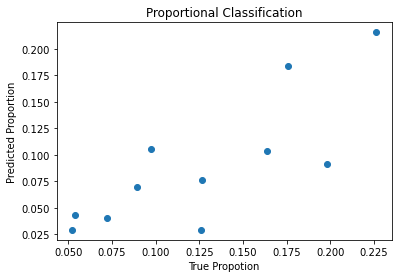

In [ ]:
plt.scatter(diff_bias['pos_freq'], diff_bias['clf_pos_freq'])
plt.xlabel('True Propotion')
plt.ylabel('Predicted Proportion')
plt.title('Proportional Classification');

In [ ]:
import numpy as np
print('Pearson r: %.3f'%np.corrcoef(diff_bias['pos_freq'],diff_bias.clf_pos_freq)[0][1])
print('RMSD freq: %.3f'%sklearn.metrics.mean_squared_error(diff_bias.pos_freq,diff_bias.clf_pos_freq))
print('RMSD abs: %.3f'%sklearn.metrics.mean_squared_error(diff_bias.pos,diff_bias.tp+diff_bias.fp))

Pearson r: 0.793
RMSD freq: 0.003
RMSD abs: 1169.727


## Investigate consequences for research question: 
###*Which minority insults are most are most frowned upon and most accepted.*
Use the reaction columns `['funny','likes','sad','disagree']` to compute a reponse score for each minority group.

In [ ]:
# Collapse the minority columns to one column for easy access.
def collapse_minority_cols(row):
  cols = []
  for col in minority_columns:
      if row[col]>0.5:
        cols.append(col)
  if len(cols)==0:
    return ['None']
  return cols
val_df['minority'] = val_df.apply(collapse_minority_cols,axis=1)



In [11]:
#df.columns
response_cols = [ 'funny', 'wow',
       'sad', 'likes', 'disagree']

val_df.groupby('label')[response_cols].mean()


,funny,wow,sad,likes,disagree
label,,,,,
0,0.279366,0.043932,0.110482,2.451994,0.572788
1,0.230139,0.045122,0.115679,2.459756,0.627003


In [ ]:
## Which Minority insults are most okay / most funny. I.e. gets most positive reactions comared to negative reactions.
react = val_df.explode('minority').groupby(['minority','label']).apply(lambda x: (x['funny']+x['likes']-(x['disagree']+ x['sad'])).mean()).unstack().sort_values(1)[1]

In [ ]:
react.sort_values()

minority
intellectual_or_learning_disability    0.000000
buddhist                               0.571429
bisexual                               1.000000
jewish                                 1.111111
asian                                  1.354839
white                                  1.409524
transgender                            1.478261
black                                  1.554945
psychiatric_or_mental_illness          1.600000
female                                 1.669355
hindu                                  1.684211
latino                                 1.730769
male                                   1.751592
muslim                                 1.818182
None                                   1.826572
christian                              2.233333
homosexual_gay_or_lesbian              2.344828
atheist                                2.470588
heterosexual                           2.941176
physical_disability                    3.000000
Name: 1, dtype: float64

Apparently Physical Disability,heterosexual and atheists are the most okay. Where buddhist jewish and asian is **NOT OKAY**

In [ ]:
react_clf.sort_values()

minority
hindu                                 -0.250000
jewish                                 0.235294
buddhist                               0.500000
muslim                                 0.540541
heterosexual                           0.666667
female                                 0.884615
christian                              1.033333
psychiatric_or_mental_illness          1.086957
black                                  1.348624
homosexual_gay_or_lesbian              1.419355
None                                   1.497925
male                                   1.537313
white                                  1.585586
latino                                 1.750000
atheist                                2.000000
asian                                  2.000000
transgender                            2.562500
bisexual                               2.800000
intellectual_or_learning_disability         NaN
physical_disability                         NaN
Name: 1, dtype: float64

Text(0, 0.5, 'classifier Based estimate')

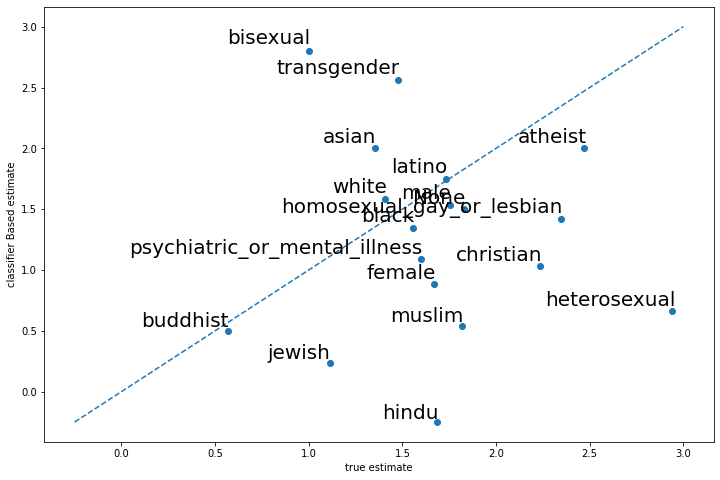

In [ ]:
## Compare to Estimates made by the classifier
react_clf = df.explode('minority').groupby(['minority','tf_prediction']).apply(lambda x: (x['funny']+x['likes']-(x['disagree']+ x['sad'])).mean()).unstack().sort_values(1)[1]
plt.figure(figsize=(12,8))
plt.scatter(react,react_clf[react.index])
for idx in react.index:
  xi,yi = react[idx],react_clf[idx]
  plt.annotate(idx,(xi,yi),
        fontsize=20,
                textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', alpha=0))
max_ = max(list(react.values)+list(react_clf.values))
min_ = min(list(react.values)+list(react_clf.values))
plt.plot(np.linspace(min_,max_),np.linspace(min_,max_),linestyle='--')
plt.xlabel('true estimate')
plt.ylabel('classifier Based estimate')


The plot above shows that the classifier based estimate will make you conclude that bisexual and transgender insults are much more Okay (they seem to get more likes+funny than disagree and sad), and in the other end underestimating how okay it is to insult heterosexuals.

## 9.2 Correct the Bias using "Ideal Method" (i.e. that labelled and unlabelled are drawn randomly from the same distribution).
Here we need to split the data into 3 sets: train, eval, and test. Because we need a decent amount of samples in the evaluation set, we need to use more of the "expensive" labelled data. Luckily we have a large toxicity dataset referenced under `tox_df` if you use my loading cell. 
  1. Train a new classifier on train data. 
  2. Estimate aggregrate confusion matrix, and then for individual minority groups on the evaluation data.
  3. Apply classifier to the rest of the data (i.e. the test set) and correct the predictions. Report the proportional classification error as above, and comment on the improvement.

In [ ]:
# Compute prediction made by your models
test_df['tf_prob'] = tfmodel.predict(test_df.comment_text)
test_df['tf_prediction'] = (test_df.tf_prob>0.5).astype(int)
x_trans = baseline.vectorizer.transform(test_df.comment_text)
test_df['bow_prob'] = baseline.predict(x_trans)[:,1]
test_df['bow_pred'] = (test_df.bow_prob>0.5).astype(int)

train_df['tf_prob'] = tfmodel.predict(train_df.comment_text)
train_df['tf_prediction'] = (train_df.tf_prob>0.5).astype(int)
#train_df['bow_prob'] = baseline.predict(train_df.comment_text)
x_trans = baseline.vectorizer.transform(train_df.comment_text)
train_df['bow_prob'] = baseline.predict(x_trans)[:,1]
train_df['bow_pred'] = (train_df.bow_prob>0.5).astype(int)

train_df['label'] = pd.Categorical(train_df.label.astype(int))
train_df['tf_prediction'] = pd.Categorical(train_df.tf_prediction)

test_df['label'] = pd.Categorical(test_df.label.astype(int))
test_df['tf_prediction'] = pd.Categorical(test_df.tf_prediction)


In [17]:
## Solution 9.2 Bias Correction.
## Correct absolute estimate
def correct_estimate(est_df, val_df,pred_col = 'tf_prediction',true_col='label',prob_col='tf_prob'):
  tn,fn,tp,fp,mat = get_confusion_matrix(est_df)
  t_p = sum(val_df[true_col]==1)/len(val_df)
  p_hat = sum(val_df[pred_col]==1)
  n_hat = len(val_df)-p_hat
  uncorr_p = p_hat/len(val_df)
  corr_p = (tp-fp)/(tp+fp)
  corr_n = fn/(fn+tn)
  p_corr = p_hat*corr_p + n_hat*corr_n
  p_corr = p_corr/len(val_df)
  prob_est = val_df[prob_col].mean()
  # true p, uncorrection p, corrected p, p estimated using probability output instead of hardprediction.
  return t_p,uncorr_p,p_corr,prob_est  
print(correct_estimate(train_df,test_df))
print(correct_estimate(train_df,test_df,pred_col='bow_pred',prob_col='bow_prob'))

(0.15718528672606807, 0.09367146447338359, 0.13518995335694156, 0.172878235578537)
(0.15718528672606807, 0.07013936486177748, 0.12576136903590315, 0.12118998713627584)


In [ ]:
dat = []
for col in minority_columns:
  temp_train = train_df[train_df[col]>0.5]
  temp_test = test_df[test_df[col]>0.5]
  t_p,uncorr_p,p_corr,prob_est = correct_estimate(temp_train,temp_test)
  d = {'true_proportion':t_p,'uncorrected':uncorr_p,'corrected':p_corr,'corrected_prob':prob_est,'minority':col,'n':len(temp_train)}
  dat.append(d)
prop_bias = pd.DataFrame(dat).dropna()

In [ ]:
prop_bias['corr_diff'] = prop_bias['corrected']-prop_bias['true_proportion']
prop_bias['uncorr_diff'] = prop_bias['uncorrected']-prop_bias['true_proportion']

In [24]:

import altair as alt
alt.Chart(prop_bias).mark_point().encode(
    x='corr_diff',
    y='uncorr_diff',
    size = 'n',
    color='minority',
    tooltip=['n', 'minority'] # show number of training samples from minority
).interactive()

alt.Chart(...)

In [25]:

np.corrcoef(prop_bias.corrected,prop_bias.true_proportion)[0][1],np.corrcoef(prop_bias.uncorrected,prop_bias.true_proportion)[0][1]

(0.8759373703000263, 0.7915372212388888)

## 9.3. Compare to the direct estimation method suggested by Hopkins & King 2010 and Jerzak, King, and Strezhnev 2020. 
Since the methods proposed in the above papers, is based on other feature representation schemes, it is not entirely meaningful as a comparison to the *Classify-and-count" method. Instead we use the same feature representation as the classifier, i.e. the Universal Sentence Encoder, and estimate the equation.

As referenced from the text by Hopkins and King:

"*think of P(D) as the unknown “regression coefficients”  $\beta$, P(S|D) as the “explanatory variables” matrix X, and P(S) as the “dependentvariable” Y.*"

Where P(D) is the probability of a document category (observed as no. of Positive Labels in the training set). P(S) is the probability of the document feature representation (again observed in the training data). P(S|D) is the probability of the Document Representation given Document Category D, which should be estimated using the standard linear regression calculations. I.e. solve for $\beta$: 

$\beta=\left(X^{\prime} X\right)^{-1} X^{\prime} y$

So what you need to do is the following:
1. Encode the texts from the data to define your x_train and x_test.
2. Estimate P(S|D) i.e. $\beta$. **hint**: use the `np.linalg.inv` function, the `.T` and the `.dot` function.
3. Estimate Proportions of each document in the test data by taking the dot product between P(S) and $\beta$. 
4. Aggregate to estimate proportions.
  - Report overall and individual minority proportions estimated compared to the test. 
  - Report measures for Proporational classification (rmsd and correlation).



In [49]:
import numpy as np
# Solution 9.3: Direct estimation
## Encode text using the Universal Feature Encoder (hint: use the "hublayer-only"-model you clone when training your classifier)
X_train_use = basetfmodel(train_df.comment_text.values).numpy()
X_test_use = basetfmodel(test_df.comment_text.values).numpy()
B = np.linalg.inv(X_train_use.T.dot(X_train_use)).dot(X_train_use.T.dot(train_df.label))


pd.DataFrame([{'True_proportion':test_df.label.astype(int).mean(),'direct_estimate(Hopkins and King)':X_test_use.dot(B).mean(),'Classify&Count':test_df.tf_prediction.astype(int).mean()}])

,true_p,direct_estimate(Hopkins and King),Classify&Count
0,0.157185,0.161323,0.093671


In [50]:
X_use = basetfmodel(df.comment_text.values).numpy()
%time df['tf_prob'] = tfmodel.predict(df.comment_text)
df['tf_prediction'] = (df.tf_prob>0.5).astype(int)


CPU times: user 6.69 s, sys: 504 ms, total: 7.19 s
Wall time: 5.09 s


In [ ]:
dat = []
for minority in minority_columns:
  temp_idx = df[minority]>0.5
  temp_X = X_use[temp_idx.values]
  # direct estimate
  est_dir = temp_X.dot(B).mean()
  # clf and count estimate
  est_cc = df[temp_idx].tf_prediction.mean()
  ## calculate diffs
  tp = df[temp_idx].label.mean()
  diff_dir = est_dir-tp
  diff_cc = est_cc-tp
  d = {'True_proportion':tp,'direct_estimate(H&K2010)':est_dir,'Classify&Count':est_cc,'minority':minority,
       'diff_dir':diff_dir,'diff_cc':diff_cc}
  dat.append(d)
dir_est_df = pd.DataFrame(dat)

In [74]:
dir_est_df.corr()

,True_proportion,direct_estimate(H&K2010),Classify&Count,diff_dir,diff_cc
True_proportion,1.000000,0.952019,0.926245,-0.565215,-0.687052
direct_estimate(H&K2010),0.952019,1.000000,0.962278,-0.285631,-0.498952
Classify&Count,0.926245,0.962278,1.000000,-0.306603,-0.362504
diff_dir,-0.565215,-0.285631,-0.306603,1.000000,0.806506
diff_cc,-0.687052,-0.498952,-0.362504,0.806506,1.000000


## Exercise 9.4: Bias detection using critical test cases
This is about making the bias of the model visible, by questioning specific dimensions (e.g. race, gender, age).. Method is demonstrated in the paper: ["Examining Gender and Race Bias in Two Hundred Sentiment Analysis Systems"](https://arxiv.org/abs/1805.04508) by Kiritchenko & Mohammad 2018:. [data](https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip)
You will use this data to test a pretrained system. Then you will practice curate your own specific "bias-detection-scheme", by combining the methods you have learned so far: keyword exploration using the [King, Lam and Robert 2017](https://gking.harvard.edu/publications/computer-assisted-keyword-and-document-set-discovery-fromunstructured-text)'s method - exercise set for week 7, universal dependence parsing with stanfordnlp now known as the [`stanza`](https://stanfordnlp.github.io/stanza/) package. 
You will use this to create what is known as data augmentation scheme which can be used both for "bias detection" as well as "bias mitigation". 

First are some helper functions for preparing the data and models you should use. 



## Loading bias detection data

In [ ]:
## Download the equity evaluation corpus
### linux commandline version
link = 'https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip'
! wget {link}
path = link.split('/')[-1]
dir_to_extr = 'bias_dataset'
import os
if not os.path.isdir(dir_to_extr):
  os.mkdir(dir_to_extr)

#! unzip {path} -d {dir_to_extr]
os.system('unzip %s -d %s'%(path,dir_to_extr))

--2020-04-02 09:24:29--  https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1669592 (1.6M) [application/zip]
Saving to: ‘Equity-Evaluation-Corpus.zip.7’

Equity-Evaluation-C 100%[===================>]   1.59M  1.44MB/s    in 1.1s    

2020-04-02 09:24:30 (1.44 MB/s) - ‘Equity-Evaluation-Corpus.zip.7’ saved [1669592/1669592]



In [ ]:
## Download the equity evaluation corpus
### Python version
import requests
link = 'https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip'
session = requests.session()
session.headers = '' # for some reason they block explicit python requests.
response = session.get(link)
with open('Equity-Evaluation-Corpus.zip','wb') as f:
    f.write(response.content)
import zipfile
zip_ref = zipfile.ZipFile('Equity-Evaluation-Corpus.zip', 'r')
dir_to_extr = 'bias_dataset'
import os
if not os.path.isdir(dir_to_extr):
    os.mkdir(dir_to_extr)
zip_ref.extractall(dir_to_extr)
zip_ref.close()

In [ ]:
import pandas as pd
dir_to_extr = 'bias_dataset/Equity-Evaluation-Corpus'
bias_df = pd.read_csv(dir_to_extr+'/Equity-Evaluation-Corpus.csv')

## Loading the deepmoji model. 
As transfer learning is about using pretrained models, one has to be flexible in relation to the choice of deep learning framework. A working model of the DeepMoji is implemented by the [HuggingFace team](https://huggingface.co/welcome) under the name [TorchMoji](https://github.com/huggingface/torchMoji), which is basically a Pytorch implementation adapted from the python 2.7 Keras implementation made by Bjarke Felbo (https://github.com/bfelbo/DeepMoji/tree/master/deepmoji). 

The script will do the following:
- Clone the github repo. 
- Download the model weights 
- install dependencies hereunder the `emoji` python package.
- Add the torchmoji to the python syspath for easy import. 
- Load the tokenizer that deepmoji depends on.
- Load the model.
- Define a helper function for translating "literal-emojies" to unicode emojies.

In [ ]:
## clone the repository
! git clone https://github.com/huggingface/torchMoji.git
## download the pretrained model's weights using their script
import os
cwd = os.getcwd()
os.chdir('torchMoji')
! python scripts/download_weights.py

import os
#os.chdir('torchMoji')
# navigate to the torchmoji folder
## install dependencies
#! pip install -e 
! pip install emoji

Cloning into 'torchMoji'...
remote: Enumerating objects: 143, done.
remote: Total 143 (delta 0), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (143/143), 2.41 MiB | 4.19 MiB/s, done.
Resolving deltas: 100% (49/49), done.
About to download the pretrained weights file from https://www.dropbox.com/s/q8lax9ary32c7t9/pytorch_model.bin?dl=0#
The size of the file is roughly 85MB. Continue? [y/n]
y
Downloading...
Running system call: wget https://www.dropbox.com/s/q8lax9ary32c7t9/pytorch_model.bin?dl=0# -O /content/torchMoji/model/pytorch_model.bin
--2020-04-02 12:00:35--  https://www.dropbox.com/s/q8lax9ary32c7t9/pytorch_model.bin?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/q8lax9ary32c7t9/pytorch_model.bin [following]
--2020-04-02 12:00:35--  https://www.dropbox.com/s/raw/q

In [ ]:
# add to sys.path
import sys
base_path = '' # change if you have downloaded folder elsewhere.
base_path = 'torchMoji/' ## path to the torchmoji directory
sys.path.insert(0, base_path)

In [ ]:
from torchmoji.sentence_tokenizer import SentenceTokenizer
# load the deepmoji encoder that transforms text to emojies.
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH
import json,csv, numpy as np
import warnings; warnings.simplefilter('ignore')


## set the max context length
max_token = 30 ## This will not work for longer texts,
################# here you should consider splitting each text into smaller segments.

# Load vocab (i.e. the index of each word in the vector representation)
with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)

# initialize tokenizer
sentence_tokenizer = SentenceTokenizer(vocabulary, max_token)
# load model
model = torchmoji_emojis(PRETRAINED_PATH)

### Load emoji translater to map output dimensions of the DeepMoji to unicode Emojies.

In [ ]:
# Change working directory back to normal. 
os.chdir(cwd)
with open(base_path+'data/emoji_codes.json') as f:
    emoji_desc = json.load(f)
print(list(emoji_desc.items())[0:10])
import emoji
def translate_emoji(emoji_descr):
    if emoji_descr in emoji.unicode_codes.EMOJI_ALIAS_UNICODE:
        return emoji.unicode_codes.EMOJI_ALIAS_UNICODE[emoji_descr]
    if emoji_descr in emoji.unicode_codes.EMOJI_UNICODE:
        return emoji.unicode_codes.EMOJI_UNICODE[emoji_descr]
    return emoji_descr
to_emoji = [translate_emoji(desc) for i,desc in sorted(emoji_desc.items(),key=lambda x: int(x[0]))]
to_emoji_desc = [desc for i,desc in sorted(emoji_desc.items(),key=lambda x: int(x[0]))]
## index 
to_emoji[0],to_emoji_desc[0]

[('0', ':joy:'), ('1', ':unamused:'), ('2', ':weary:'), ('3', ':sob:'), ('4', ':heart_eyes:'), ('5', ':pensive:'), ('6', ':ok_hand:'), ('7', ':blush:'), ('8', ':heart:'), ('9', ':smirk:')]


('😂', ':joy:')

### Now we are ready to encode the text as emojis using the pretrained model.


9.1.1: Investigate the bias of the [DeepMoji](https://deepmoji.mit.edu/) classifier from the paper ["Using millions of emoji occurrences to learn any-domain representations for detecting sentiment, emotion and sarcasm"](https://arxiv.org/pdf/1708.00524.pdf) using the Kiritchenko & Mohammed 2018 [dataset](https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip)

The dataset contains identical sentences changing only the name of the person being referenced. 

Dataset used is referenced under the `bias_df`.

|    | ID                    | Sentence                | Template                               | Person   | Gender   | Race             | Emotion   | Emotion word   |
|---:|:----------------------|:------------------------|:---------------------------------------|:---------|:---------|:-----------------|:----------|:---------------|
|  0 | 2018-En-mystery-05498 | Alonzo feels angry.     | <person subject> feels <emotion word>. | Alonzo   | male     | African-American | anger     | angry          |
|  1 | 2018-En-mystery-11722 | Alonzo feels furious.   | <person subject> feels <emotion word>. | Alonzo   | male     | African-American | anger     | furious        |
|  2 | 2018-En-mystery-11364 | Alonzo feels irritated. | <person subject> feels <emotion word>. | Alonzo   | male     | African-American | anger     | irritated      |


The deepmoji model is referenced under as `model`.

And the tokenizer is referenced as `sentence_tokenizer`.

You should now do the following:

1. Tokenization. Tokenize the documetns in the `bias_dataset`.
  - Use the `sentence_tokenizer` defined above to tokenize the documents.

  - see example in the torchmoji examples [e.g.](https://github.com/huggingface/torchMoji/blob/master/examples/encode_texts.py) folder for help.

  - Inspect the tokenized documents to see the format.
  - Try to convert them back using <code>vocabulary</code> variable defined earlier. **- Hint this means reversing the vocabulary dictionary.**
2. DeepMoji encoding
  - Encode the tokenized sentences and wrap it in a function.
  - Hint: Do a forward pass of the model on the tokenized data. Check [here](https://github.com/huggingface/torchMoji/blob/master/examples/encode_texts.py) for help 

  - For larger datasets and with longer sentences encoding is problematic if not done in batches. 
  - Write a for loop that takes only 256 tokenized documents at a time and concatenate them to a dataframe in the end.
  - Use the <code>to_emoji list </code> as columns in the dataframe
3. Join DeepMoji Encoding with the `bias_df`.
  -  Join the output of Deepmoji with the bias dataframe columns (Race, Gender and Emotion)
  - Make sure Race count and Gender counts are equal after join.
  - Investigate if there are significant differences in relation to **Race** (Race column).
  - See which types of emojies are most changed by a change in race or gender.
  - See which *Emotions* (Emotion column) have largest difference in encoding in relation to different races. 
    - I.e. Groupby Emotion and Race and calculate absolute difference in emoji encoding. 
    - hint: first groupby emotion and race, calculate mean, then diff, then abs and then sum.


In [ ]:
## Solution 9.1.1 Tokenization
docs = bias_df.Sentence.values
%time tokenized, _, stats = sentence_tokenizer.tokenize_sentences(docs)
tokenized[0]

CPU times: user 1.17 s, sys: 7.58 ms, total: 1.18 s
Wall time: 1.19 s


array([33306,  1459,  1740,    11,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=uint16)

In [ ]:
## reverse indexing
vocab = sorted(vocabulary,key=lambda x: vocabulary[x])
[vocab[i] for i in tokenized[0]][0:15]



['alonzo',
 'feels',
 'angry',
 '.',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK',
 'CUSTOM_MASK']

In [183]:
n_batch = 256
bs = len(tokenized)//n_batch
enc = []
import tqdm
import pandas as pd
def emoji_encode(tokenized,to_df=False):
    #tokenized, _, _ = sentence_tokenizer.tokenize_sentences(texts)
    probs = model(tokenized)
    if to_df:
        return pd.DataFrame(probs,columns=to_emoji_desc)
    return probs

for i in tqdm.tqdm(list(range(n_batch))):
    batch = tokenized[i*bs:(i+1)*bs]
    emoji_encoded = emoji_encode(batch,to_df=True)
    enc.append(emoji_encoded)
batch = tokenized[(i+1)*bs:]
emoji_encoded = emoji_encode(batch,to_df=True)
enc.append(emoji_encoded)

100%|██████████| 256/256 [00:17<00:00, 14.83it/s]


In [192]:
emoji_df = pd.concat(enc)
emoji_df.columns = to_emoji

In [ ]:
# Solution 9.1.1 Analyzing how Gender and Race alone changes the DeepMoji encoding
# Add columns
for col in ['Race','Gender','Emotion']: 
    emoji_df[col] = bias_df[col].values
# Compute emoji mean for each Race
race2emoji = emoji_df.groupby('Race').mean()

race2emoji = race2emoji[sorted(emo2sent,key=lambda x: emo2sent[x])]
sort_diff = abs(race2emoji.diff(-1)).T.sort_values('African-American',ascending=False).index
race2emoji = race2emoji[sort_diff]
# Emojies with highest difference in relation to Race
race2emoji.T.head(5)
# Emotion with higest difference in relation to Race.
emoji_df.groupby(['Emotion','Race']).mean().groupby('Emotion').diff().apply(abs).sum(axis=1)

In [16]:
# Join the output of Deepmoji with the bias dataframe columns (Race, Gender and Emotion)
for col in ['Race','Gender','Emotion']:
    emoji_df[col] = bias_df[col].values
# Make sure Race count and Gender counts are equal after join.
emoji_df.Race.value_counts()

European            2880
African-American    2880
Name: Race, dtype: int64

In [ ]:
# Investigate if there are significant differences in relation to Race (Race column).
#    See which types of emojies are most changed by a change in race or gender.
race2emoji = emoji_df.groupby('Race').mean()
geneder2emoji = emoji_df.groupby('Gender').mean()
def get_sorted_diff(df,absolute_diff=True):
    diff = df.diff(-1).dropna()
    if absolute_diff:
        diff = abs(diff)    
    sort_diff = diff.T.sort_values(diff.T.columns[0],ascending=False).index
    return df[sort_diff]



In [50]:
get_sorted_diff(race2emoji,absolute_diff=False).T.head()

Race,African-American,European
💀,0.033696,0.025895
😕,0.031760,0.027590
💯,0.007194,0.003867
😩,0.015215,0.012098
😤,0.016986,0.013905


In [52]:
get_sorted_diff(race2emoji,absolute_diff=False).T.tail()

Race,African-American,European
🙈,0.013948,0.016176
😂,0.032415,0.034823
😅,0.021984,0.024440
💔,0.038261,0.043322
😳,0.039918,0.045626


In [46]:
get_sorted_diff(gender2emoji,absolute_diff=False).T.head()

Gender,female,male
😳,0.045877,0.040518
💁,0.010419,0.007244
🙅,0.009200,0.007507
👏,0.016385,0.015279
😁,0.017602,0.016592


In [47]:
get_sorted_diff(gender2emoji,absolute_diff=False).T.tail()

Gender,female,male
😢,0.029893,0.032295
😪,0.023895,0.026322
😓,0.025578,0.028041
😔,0.037701,0.040315
😞,0.033767,0.036434


In [110]:
#   See which Emotions (Emotion column) have largest difference in encoding in relation to different races.
def get_diff_emotion(df,col):
    diff = df.groupby(['Emotion',col]).mean().diff().dropna()
    diff_vals = abs(diff.values[::2,:]).sum(axis=1)
    idx = [i for i, j in diff.index[::2]]
    return pd.DataFrame(diff_vals,index=idx,columns=['abs_diff']).sort_values('abs_diff')#,columns=emoji_df.columns[:-3],index=idx)

In [125]:
get_diff_emotion(emoji_df,col='Race')
# Fear is the emotion where the model is most influenced by Race

,abs_diff
sadness,0.086262
joy,0.092333
anger,0.096118
fear,0.105285


In [126]:
get_diff_emotion(emoji_df,col='Gender')
# Gender influence the model mostly on the Fear and Joy dimensions.

,abs_diff
anger,0.046928
sadness,0.048079
joy,0.063092
fear,0.067824


In [129]:
# Absolute change 
get_diff_emotion(emoji_df,col='Gender').sum().values[0],get_diff_emotion(emoji_df,col='Race').sum().values[0]
# Race bias the model more than Gender.

(0.22592285, 0.3799974)

## Exercise 9.4.1: Create your own test case by substituting minority identifiers in the toxicity dataset.

The key to the bias test was substituting using the same sentences but with different subjects in the sentence, (Alonzo, Alan, He, she) etc. We can construct a similar dataset by *Augmenting* the toxicity dataset (referenced as `df`).
- First we create our minority identifiers that we want to substitute / remove. Could have been done iteratively using Exploration methods like (word similarity search or active learning style keyword discovery from most predictive features). 
  - Instead we will pick most predictive phrases from each minority category in the data. 
    1. Because we will use it for our data augmentation scheme we want slightly more information than just words. We therefore tokenize and process documents using the standfordnlp package. ```! pip install stanza
import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline```
    2. Aply the nlp pipeline to all documents.
    3. Extract word and wordtype pairs from all documents. i.e. a document will look like this: `[(w, wtyp), (w1,wtyp) ... (wi,wtyp)]`. Remember to lowercase.
    4. Use the `bow_to_sparse` helper function to create an index using the most prevalent word,wordtype pairs and transform the documents to bows. The function returns `sparse_matrix,index`, which denotes a matrix of word_pair counts, and the corresponding index of each wordpair. 
    5. Train a classifier (logistic regression) for each minority column.
    6. Extract most predictive features (i.e. `.coef_`). 
    7. Go through the phrases and pick the most useful (at least 10).
  - Do the above for at least 3 different minorities.  

- Now we want to Remove the minority identifiers and see how our model does.
  - Write a function that takes a list of identifiers and replaces them with a pattern. 
    - `def change_identifier(identifiers,replace_pattern=''):` 
  - Apply the function `change_identifier` function to the texts to create your *"augmented"* dataset.
  - Train two models:
    - One on all the texts. 
    - One with on the *augmented* the texts where all minority identifiers are 
  - Report the differences in predictions. 



In [ ]:

! pip install stanza
import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline

     |████████████████████████████████| 194kB 7.2MB/s eta 0:00:01


2020-04-02 12:01:47 INFO: Downloading default packages for language: en (English)...
2020-04-02 12:06:06 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-04-02 12:06:06 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| ner       | ontonotes |

2020-04-02 12:06:06 INFO: Use device: gpu
2020-04-02 12:06:06 INFO: Loading: tokenize
2020-04-02 12:06:15 INFO: Loading: pos
2020-04-02 12:06:16 INFO: Loading: lemma
2020-04-02 12:06:16 INFO: Loading: depparse
2020-04-02 12:06:17 INFO: Loading: ner
2020-04-02 12:06:17 INFO: Done loading processors!


In [ ]:
nlp_docs = []
import tqdm
for doc in tqdm.tqdm(df.comment_text):
  nlp_docs.append(nlp(doc))

100%|██████████| 5707/5707 [17:15<00:00,  5.51it/s]


In [ ]:
def extract_word_pairs(doc):
  wordpairs = []
  for sent in doc.sentences:
      for word in sent.words:
          d = word.to_dict()
          wordpairs.append((d['text'].lower(),d['upos']))
  return wordpairs
wordpairs = []
for doc in nlp_docs:
  wordpairs.append(extract_word_pairs(doc))

In [ ]:
import scipy.sparse as sp
from collections import Counter
def bow_to_sparse(docs,max_vocab_size=32768):
    c = Counter()
    bows = []
    for doc in docs:
      bow = Counter(doc)
      bows.append(bow)
      c.update(bow)
    w2i = {w:num for num,(w,count) in enumerate(c.most_common()[0:max_vocab_size])}

    idx = sorted(w2i,key=lambda x: w2i[x])
    vocab_size = len(idx)
    X = sp.dok_matrix((len(docs),vocab_size), dtype=np.int32)
    for num in range(len(docs)):
        bow = bows[num]
        for w,count in bow.items():
            try:
              wi = w2i[w]
            except:
              continue
            X[num,wi]=count
    print(X.shape)
    X = X.tocsr()
    print(X.shape)
    return X,idx


In [ ]:
X,idx = bow_to_sparse(wordpairs)

(5707, 26764)
(5707, 26764)


In [ ]:
# Prepare for cross validation, augmentation should only be of the training data.
df['idx'] = np.arange(len(df))
train_idx = df.loc[train_df.index].idx.values
test_idx = df.loc[test_df.index].idx.values
y_train = df.label.values[train_idx]
y_test = df.label.values[test_idx]
X_train,X_test = X[train_idx],X[test_idx]

In [ ]:
min2set = {}

In [23]:
import sklearn.linear_model
minority = set(['jewish','black','white','asian'])
minority_columns = strat_sample_cols[5:]
for col in minority_columns:
  if col not in minority:
    continue
  print()
  print('______________')
  print(col)
  #if len(min2set[col])>0:
   # continue
  y = (df[col]>0.5).values
  model = sklearn.linear_model.LogisticRegression()
  model.fit(X,y)
  coefs = model.coef_
  s = []
  print()
  for i in np.argsort(coefs)[0][::-1][:30]:
    #print(,end='\r')
    inp = input('%r-%r press y or enter. b to break'%(idx[int(i)]))
    print(end='\r')
    if inp=='y':
      s.append([(i,idx[i])])
    if inp=='b':
      break
  min2set[col] = s
    



______________
asian

'asian'-'ADJ' press y or enter. b to breaky
'asians'-'PROPN' press y or enter. b to breaky
'chinese'-'ADJ' press y or enter. b to breaky
'asia'-'PROPN' press y or enter. b to breaky
'japanese'-'ADJ' press y or enter. b to breaky
'buy'-'VERB' press y or enter. b to break
'asians'-'NOUN' press y or enter. b to breaky
'asian'-'PROPN' press y or enter. b to breaky
'trust'-'VERB' press y or enter. b to break
'anti-asian'-'ADJ' press y or enter. b to break
'put'-'VERB' press y or enter. b to break
'racism'-'NOUN' press y or enter. b to break
'knows'-'VERB' press y or enter. b to break
'hawaii'-'PROPN' press y or enter. b to break
'discriminating'-'VERB' press y or enter. b to break
'got'-'VERB' press y or enter. b to break
'know'-'VERB' press y or enter. b to break
'stepping'-'VERB' press y or enter. b to break
'china'-'PROPN' press y or enter. b to breaky
'upon'-'ADP' press y or enter. b to break
'slope'-'NOUN' press y or enter. b to break
'slippery'-'ADJ' press y or 

In [ ]:
import pickle
pickle.dump(min2set,open('/content/drive/My Drive/lm/minority_keywords','wb'))

In [ ]:
import pickle
min2set = pickle.load(open('/content/drive/My Drive/lm/minority_keywords','rb'))

9.4.2: Data augmentation to mitigate bias. Here you will create synthetic data to *mitigate* the minority biases by training the model on data where the different minority identifiers are used interchangebly.

The strategy is to create new synthetic data by substituting an identifier from e.g. "black" identifiers with "white" identifiers, and we want to only substitute columns with the same Wordtyp. 

- Define a function that takes Two Sets of identifiers and substitutes identifiers from each set: 
  1. Makes a copy of the training BoWs (i.e. `.copy()` function). Runs through each identifer in set 1, locates the rows where it is active and makes a copy of these rows. 
  2. Sets identifer column to 0.
  3. For each identifier in set 2 that match the same wordtype, make a copy of the rows. Set identifier column to 1 and append to list. 
  4. Concatenate these sparsematrices to one sparse matrix using the `scipy.sparse.vstack` function.

- Apply the function to create extra synthethic data using all identifier sets.
- Train a classifier using both the old and new synthetic data and investigate its differential bias.



In [ ]:
# Solution 9.2.2 Dataaugmentation
## Build network to match words from the same class.
import networkx as nx
w2typ_g = nx.Graph()
for l in min2set.values():
  for i in l:
    i = i[0]
    wid = i[0]
    wpair = i[1]
    w,typ = wpair
    w2typ_g.add_edge(wid,typ)
# Substitution function
def substitute(wid):
  typ = idx[wid][1]
  similar = w2typ_g[typ].copy()
  new_rows = []
  y = []
  for i in similar:
    
    temp_idx = (X_train[:,i]>0).todense()

    temp_idx = np.asarray(temp_idx).reshape(1,-1)[0,:]
    
    rows = X_train[temp_idx].copy()
    rows[:,i] = 0
    rows[:,wid] = 1
    new_rows.append(rows)
    y.append(y_train[temp_idx])
  return new_rows,y
# Create synthetic dataset
augmented_data = []
ys = []
for minority,wpairs in min2set.items():
  for i in wpairs:
    wid,wpair = i[0]
    rows,y = substitute(wid)
    augmented_data+= rows
    ys+=y

In [ ]:
augmented_mat = sp.vstack(augmented_data)
y_aug = np.concatenate(ys)

In [ ]:
# compile augmented training set
X_train_aug = sp.vstack([X_train,augmented_mat])
y_train_aug = np.concatenate([y_train,y_aug])


In [ ]:
# Train Classifier.
model = sklearn.linear_model.LogisticRegression()
model.fit(X_train,y_train)
pred = model.predict(X_test)

model_aug = sklearn.linear_model.LogisticRegression()
model_aug.fit(X_train_aug,y_train_aug)
aug_pred = model_aug.predict(X_test)


In [ ]:
test_df['augmented_pred'] = aug_pred
test_df['pred'] = pred

In [108]:
(test_df.pred==test_df.label).mean(),(test_df.augmented_pred==test_df.label).mean()
# Performance has been reduced only slightly

(0.8584797991326181, 0.8523168226432322)

In [ ]:
dat = []
for minority in minority_columns:
  groupdf = test_df[test_df[minority]>0.5]
  acc = (groupdf.label==groupdf.pred).mean()
  acc_aug = (groupdf.label==groupdf.augmented_pred).mean()
  d = {'minority':minority,'acc':acc,'aug_acc':acc_aug}
  dat.append(d)

In [3]:
#pd.DataFrame(dat)

## Extra
- Implement a simple semi-supervised learning classifier. 

- Compute the lift curve. What does the graph tell you about the Saturation of your classifier?


